# Mistral vs LLama 2 vs Gemma

### Import Libraries

In [1]:
from encoder.encoder import Encoder
from retriever.vector_db import VectorDatabase
from langchain.docstore.document import Document
from generator.generator import Generator
import pandas as pd
import time
import seaborn as sns
import matplotlib.pyplot as plt
import re


llama = Generator(model='llama')
mistral = Generator(model='mistral')
gemma = Generator(model='gemma')
encoder = Encoder()
vectordb = VectorDatabase(encoder.encoder)

llama_model_loader: loaded meta data with 19 key-value pairs and 291 tensors from /Users/rafael/Documents/lab/large-language-models/gemma/model/nous-hermes-llama-2-7b.Q4_K_M.gguf (version GGUF V2)
llama_model_loader: Dumping metadata keys/values. Note: KV overrides do not apply in this output.
llama_model_loader: - kv   0:                       general.architecture str              = llama
llama_model_loader: - kv   1:                               general.name str              = LLaMA v2
llama_model_loader: - kv   2:                       llama.context_length u32              = 4096
llama_model_loader: - kv   3:                     llama.embedding_length u32              = 4096
llama_model_loader: - kv   4:                          llama.block_count u32              = 32
llama_model_loader: - kv   5:                  llama.feed_forward_length u32              = 11008
llama_model_loader: - kv   6:                 llama.rope.dimension_count u32              = 128
llama_model_loader: - k

### Load Data and insert into vector database

In [2]:
df = pd.read_csv("data/data.csv")

In [6]:
df["full_review"] = df[["reviews.title", "reviews.text"]].apply(
    lambda row: ". ".join(row.values.astype(str)), axis=1
)
for product_id in df["asins"].unique()[:10]:
    # create documents to store in Postgres
    docs = [
        Document(page_content=item)
        for item in df[df["asins"] == product_id]["full_review"].tolist()
    ]

    passages = vectordb.create_passages_from_documents(docs)
    vectordb.store_passages_db(passages, product_id)

Collection not found
Collection not found
Collection not found
Collection not found
Collection not found
Collection not found
Collection not found
Collection not found
Collection not found
Collection not found


### Generate queries and context

In [7]:
# generate 2 questions for each product id (20 questions in total)
questions = [f"{product_id}|What people like about the product?" for product_id in df["asins"].unique()[:10]] + [f"{product_id}|What people dislike about the product?" for product_id in df["asins"].unique()[:10]]

# retrieve query and context to give to llama and mistral
QUERIES = []
CONTEXTS = []

for q in questions:
    id = q.split("|")[0]
    query = q.split("|")[1]
    context = vectordb.retrieve_most_similar_document(query, k=2, id=id)
    QUERIES.append(query)
    CONTEXTS.append(context)

### Create dictionary to save metrics

In [2]:
llama_metrics = {
    "words_per_second": [],
    "words": []
}

mistral_metrics = {
    "words_per_second": [],
    "words": []
}

gemma_metrics = {
    "words_per_second": [],
    "words": [],
}

### Gather metrics

In [4]:
for query, context in zip(QUERIES, CONTEXTS):

    # llama
    init_time = time.time()
    answer = llama.get_answer(context, query)
    total_time = time.time()-init_time
    llama_metrics["words_per_second"].append(len(re.sub("[^a-zA-Z']+", ' ', answer).split())/total_time)
    llama_metrics["words"].append(len(re.sub("[^a-zA-Z']+", ' ', answer).split()))

    # mistral
    init_time = time.time()
    answer = mistral.get_answer(context, query)
    total_time = time.time()-init_time
    mistral_metrics["words_per_second"].append(len(re.sub("[^a-zA-Z']+", ' ', answer).split())/total_time)
    mistral_metrics["words"].append(len(re.sub("[^a-zA-Z']+", ' ', answer).split()))

    # gemma
    init_time = time.time()
    answer = gemma.get_answer(context, query)
    total_time = time.time()-init_time
    gemma_metrics["words_per_second"].append(len(re.sub("[^a-zA-Z']+", ' ', answer).split())/total_time)
    gemma_metrics["words"].append(len(re.sub("[^a-zA-Z']+", ' ', answer).split()))

/Users/rafael/miniconda3/envs/zaai/lib/python3.10/site-packages/langchain_core/_api/deprecation.py:117: LangChainDeprecationWarning: The function `run` was deprecated in LangChain 0.1.0 and will be removed in 0.2.0. Use invoke instead.
  warn_deprecated(

llama_print_timings:        load time =   11342.70 ms
llama_print_timings:      sample time =      39.86 ms /   109 runs   (    0.37 ms per token,  2734.91 tokens per second)
llama_print_timings: prompt eval time =   43763.65 ms /   322 tokens (  135.91 ms per token,     7.36 tokens per second)
llama_print_timings:        eval time =   24875.99 ms /   108 runs   (  230.33 ms per token,     4.34 tokens per second)
llama_print_timings:       total time =   69128.61 ms /   430 tokens

llama_print_timings:        load time =   11491.93 ms
llama_print_timings:      sample time =      30.43 ms /    86 runs   (    0.35 ms per token,  2826.16 tokens per second)
llama_print_timings: prompt eval time =   44685.77 ms /   319 tokens (  140.08 ms 

### Metrics comparison

#### Mistral 7B vs Llama 2 7B vs Gemma 7B

In [5]:
mistral_metrics = pd.DataFrame(mistral_metrics)
mistral_metrics['model'] = 'Mistral 7B'
llama_metrics = pd.DataFrame(llama_metrics)
llama_metrics['model'] = 'Llama 2 7B'
gemma_metrics = pd.DataFrame(gemma_metrics)
gemma_metrics['model'] = 'Gemma 7B'

# create single data frame for plotting
metrics = pd.concat([mistral_metrics, llama_metrics, gemma_metrics])

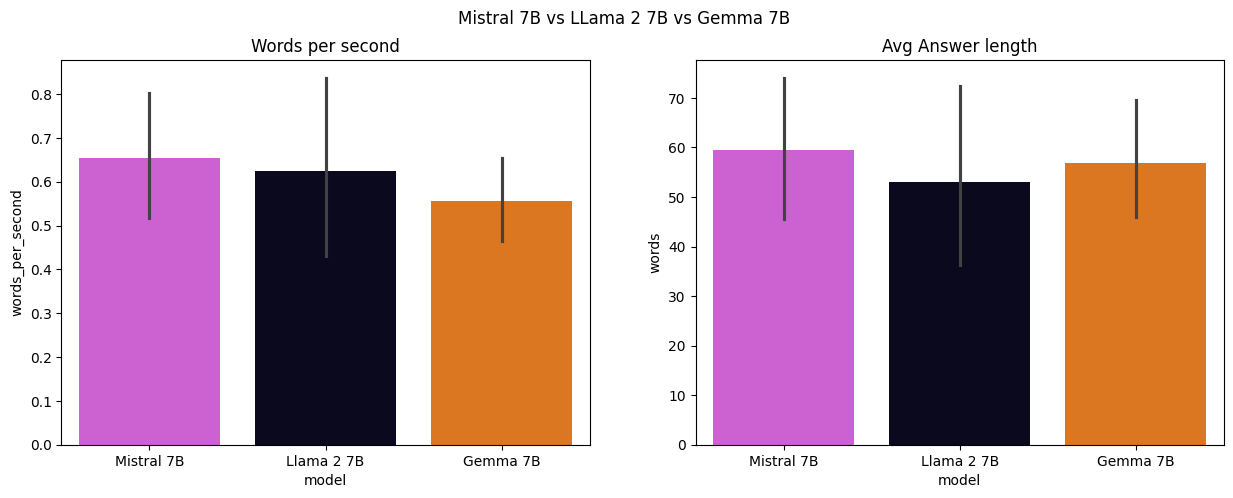

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('Mistral 7B vs LLama 2 7B vs Gemma 7B')

sns.barplot(ax=axes[0], data=metrics, y='words_per_second', x='model', hue='model', palette=["#dd4fe4", "#070620", "#fa7302"])
axes[0].set_title("Words per second")

sns.barplot(ax=axes[1], data=metrics, y='words', x='model', hue='model', palette=["#dd4fe4", "#070620", "#fa7302"])
axes[1].set_title("Avg Answer length")

plt.show()

In [7]:
print("Mistral 7B answer:")
print(mistral.get_answer(CONTEXTS[1], QUERIES[1]))
print("-------------")

print("LLama 2 7B answer:")
print(llama.get_answer(CONTEXTS[1], QUERIES[1]))

print("Gemma 7B answer:")
print(gemma.get_answer(CONTEXTS[1], QUERIES[1]))

Mistral 7B answer:


Llama.generate: prefix-match hit

llama_print_timings:        load time =   11491.93 ms
llama_print_timings:      sample time =      22.98 ms /    65 runs   (    0.35 ms per token,  2828.18 tokens per second)
llama_print_timings: prompt eval time =   19831.71 ms /   101 tokens (  196.35 ms per token,     5.09 tokens per second)
llama_print_timings:        eval time =   15040.72 ms /    64 runs   (  235.01 ms per token,     4.26 tokens per second)
llama_print_timings:       total time =   35279.66 ms /   165 tokens
Llama.generate: prefix-match hit


 People like the product because it is easy to use, the screen is easy to read, the battery life is long, and they can use it for travel and at the beach. Additionally, people like that the product is updated with newer versions and they enjoy using it even if they did not originally buy it for themselves.
-------------
LLama 2 7B answer:



llama_print_timings:        load time =   11342.70 ms
llama_print_timings:      sample time =      39.54 ms /   108 runs   (    0.37 ms per token,  2731.55 tokens per second)
llama_print_timings: prompt eval time =   21544.14 ms /   103 tokens (  209.17 ms per token,     4.78 tokens per second)
llama_print_timings:        eval time =   24405.79 ms /   107 runs   (  228.09 ms per token,     4.38 tokens per second)
llama_print_timings:       total time =   46559.87 ms /   210 tokens
Llama.generate: prefix-match hit


1) It's a great way to read books on a device instead of carrying around a physical copy.
        2) The battery life is long so you can read for hours without having to worry about charging.
        3) The screen is easy to read even in bright sunlight or low light conditions.
        4) The device is lightweight and portable so you can take it with you wherever you go.
        5) It's easy to navigate through books on the device using its interface.
Gemma 7B answer:



llama_print_timings:        load time =   14468.73 ms
llama_print_timings:      sample time =     154.75 ms /    54 runs   (    2.87 ms per token,   348.95 tokens per second)
llama_print_timings: prompt eval time =   27098.20 ms /   100 tokens (  270.98 ms per token,     3.69 tokens per second)
llama_print_timings:        eval time =   15291.33 ms /    53 runs   (  288.52 ms per token,     3.47 tokens per second)
llama_print_timings:       total time =   44315.41 ms /   153 tokens


Sure! Here is your Answer:

People like about  the  product its ease-of-use , readability , battery life , compact size , versatility ,  nice design ,  nice reading experience ,  and its ability  to be used in various settings .
